In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [16]:
from LinearKalmanNet import LinearKalmanNet
from KalmanNet import KalmanNet
from utils import generate_data, train
from Kalman import KalmanFilter
from ExtendedKalmanFilter import ExtendedKalmanFilter
from LinearSystem import LinearSystem
from NonLinearSystem import NonlinearSystem

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


# Testcase 1: Lineární systém
Předpoklad, že uvažovaný model systému je identický jako samotný systém. Kromě počátečních podmínek.

In [38]:
# --- Reálný systém ---
F_true = torch.tensor([[0.5]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Očekávaná hodnota počátečního stavu
P0_true = torch.tensor([[1.2]])  # Počáteční kov

sys_true = LinearSystem(Ex0_true,P0_true,F_true, H_true, Q_true, R_true)

Ex0_model = torch.tensor([[0.5]])  # Očekávaná hodnota počátečního stavu
P0_model = torch.tensor([[1.5]])  # Počáteční kov

F_model = F_true
H_model = H_true
Q_model = Q_true
R_model = R_true
sys_model = LinearSystem(Ex0_model,P0_model,F_model,H_model,Q_model,R_model)


In [39]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200) # Jedna delší trajektorie pro test


In [40]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [41]:
kalman_filter = KalmanFilter(Ex0_model, P0_model, F_model, H_model, Q_model, R_model)
kf_data = kalman_filter.apply_filter(y_test[0])
x_hat_kf = kf_data['x_filtered']

In [42]:
knet = LinearKalmanNet(sys_model,128).to(device)
train(knet, train_loader,device,epochs=50, lr=1e-4)

Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.057912, Celková norma grad.: 0.0377
Epocha [10/50], Prům. chyba: 0.056077, Celková norma grad.: 0.0236
Epocha [15/50], Prům. chyba: 0.055293, Celková norma grad.: 0.0246
Epocha [20/50], Prům. chyba: 0.054707, Celková norma grad.: 0.0191
Epocha [25/50], Prům. chyba: 0.054226, Celková norma grad.: 0.0146
Epocha [30/50], Prům. chyba: 0.053965, Celková norma grad.: 0.0399
Epocha [35/50], Prům. chyba: 0.053814, Celková norma grad.: 0.0122
Epocha [40/50], Prům. chyba: 0.053724, Celková norma grad.: 0.0242
Epocha [45/50], Prům. chyba: 0.053653, Celková norma grad.: 0.0119
Epocha [50/50], Prům. chyba: 0.053539, Celková norma grad.: 0.0204
Trénování dokončeno.


In [43]:
knet.eval()
with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_test_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_test_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_kf = mse_criterion(x_hat_kf, x_test[0])

print(f"\nVýsledná MSE KalmanNet: {mse_knet.item():.4f}")
print(f"Výsledná MSE klasického KF: {mse_kf.item():.4f}")


Výsledná MSE KalmanNet: 0.0543
Výsledná MSE klasického KF: 0.0542


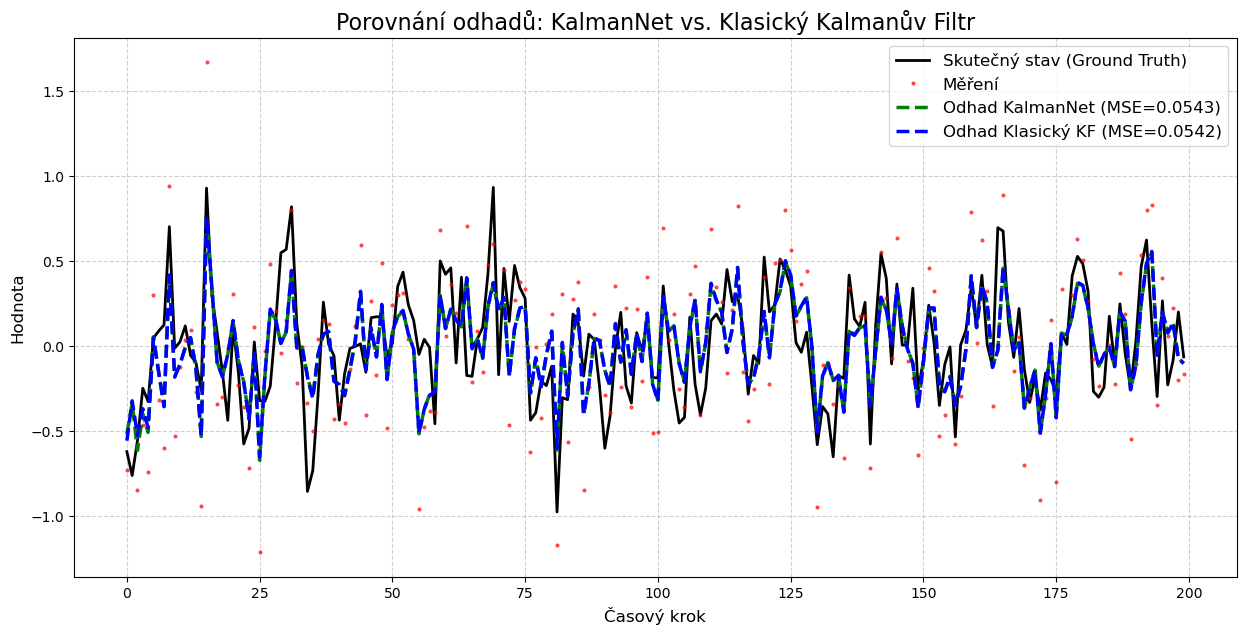

In [44]:
plt.figure(figsize=(15, 7))
plt.title("Porovnání odhadů: KalmanNet vs. Klasický Kalmanův Filtr", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_kf_plot = x_hat_kf.squeeze().numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=4, alpha=0.6, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_kf_plot, 'b--', linewidth=2.5, label=f"Odhad Klasický KF (MSE={mse_kf.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Testcase 2: Nelineární systém
Předpoklad, že uvažovaný model systému je identický jako samotný systém

In [45]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[1.0]])
sys_model= NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [46]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [48]:
ekf = ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']

In [49]:
knet_nelinearni = KalmanNet(sys_model).to(device)
train(knet_nelinearni, train_loader, device, epochs=50, lr=1e-4)

Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.143876, Celková norma grad.: 0.0417
Epocha [10/50], Prům. chyba: 0.140863, Celková norma grad.: 0.0120
Epocha [15/50], Prům. chyba: 0.138751, Celková norma grad.: 0.0199
Epocha [20/50], Prům. chyba: 0.136915, Celková norma grad.: 0.0303
Epocha [25/50], Prům. chyba: 0.135773, Celková norma grad.: 0.0750
Epocha [30/50], Prům. chyba: 0.135041, Celková norma grad.: 0.0687
Epocha [35/50], Prům. chyba: 0.134594, Celková norma grad.: 0.0454
Epocha [40/50], Prům. chyba: 0.134289, Celková norma grad.: 0.0352
Epocha [45/50], Prům. chyba: 0.134162, Celková norma grad.: 0.1044
Epocha [50/50], Prům. chyba: 0.133908, Celková norma grad.: 0.0186
Trénování dokončeno.



Výsledná MSE KalmanNet na nelineárním systému: 0.1237
Výsledná MSE EKF na nelineárním systému:       0.1239


/home/luky/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 200, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


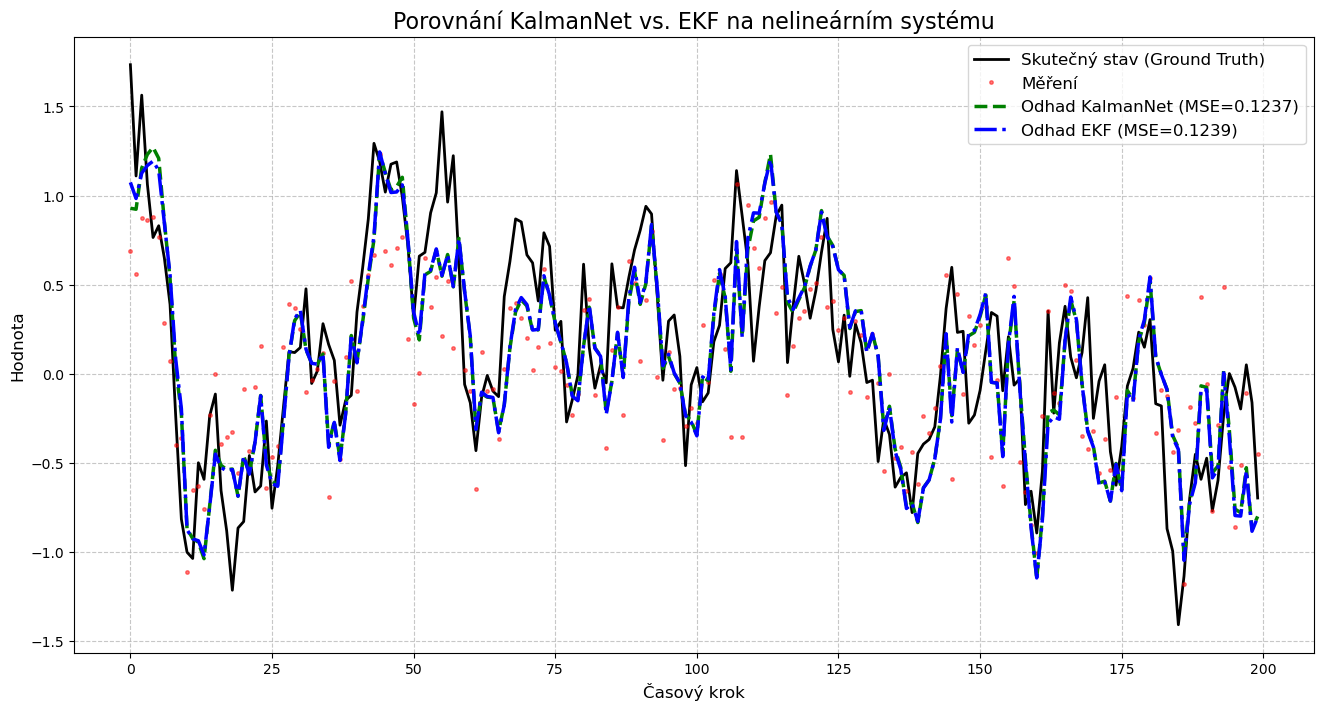

In [ ]:
knet = knet_nelinearni
knet.eval()

with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_ekf = mse_criterion(x_hat_ekf, x_test)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")
print(f"Výsledná MSE EKF na nelineárním systému:       {mse_ekf.item():.4f}")

plt.figure(figsize=(16, 8))
plt.title("Porovnání KalmanNet vs. EKF na nelineárním systému", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_ekf_plot = x_hat_ekf.numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_ekf_plot, 'b-.', linewidth=2.5, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")


plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()